# IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import pickle

from src.data_visualisation import plot_model_history
from src.data_preparation import calculate_rul,gen_sequence_and_labels
from src.model_selection import cross_validate_tf_models,r2_keras

from tensorflow.keras.layers import Dense , LSTM, GRU, Dropout, Activation, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import L1L2
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError,RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError

from sklearn.preprocessing import StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:,.2f}'.format


r:\Google Drive\Documentos - Renan\EMPREGOS\TESTES\SUZANO\Case Pulp and Paper\Suzano_env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
class StandardScalerND(StandardScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

    def transform(self,X):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2])) if X.ndim > 2 else X
        return np.reshape(super().transform(x), newshape=X.shape)

In [3]:
class MinMaxScalerND(MinMaxScaler):

    def fit_transform(self, X, y=None):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

    def transform(self,X):
        x = np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2])) if X.ndim > 2 else X
        return np.reshape(super().transform(x), newshape=X.shape)

# LER BASES ORIGINAIS

In [4]:
# Definir cabeçalho
header=['asset_id','runtime'] + [f'setting{i}' for i in range(1,4)] + [f'tag{i}' for i in range(1,22)]

In [5]:
df_train=pd.read_csv('data/PM_train.txt',sep='\s',names=header)
df_test=pd.read_csv('data/PM_test.txt',sep='\s',names=header)
print('df_train shape:',df_train.shape)
print('df_test shape:',df_test.shape)

df_train shape: (20631, 26)
df_test shape: (13096, 26)


In [6]:
df_train['RUL'] = calculate_rul(df=df_train
                                , id_col='asset_id'
                                , runtime_col='runtime'
                                )

df_test['RUL'] = calculate_rul(df=df_test
                                , id_col='asset_id'
                                , runtime_col='runtime'
                                )

# LER BASES

In [7]:
df_train_resumo=pd.read_csv('data/02_df_train_01_selecionado.csv',sep=',')
df_test_resumo=pd.read_csv('data/02_df_test_01_selecionado.csv',sep=',')
print('df_train shape:',df_train_resumo.shape)
print('df_test shape:',df_test_resumo.shape)

df_train shape: (20631, 11)
df_test shape: (13096, 11)


# Cenário 01 - RUL 
## Data Preparation

In [8]:
X_train = df_train_resumo.drop(['RUL'], axis=1)
y_train = df_train_resumo['RUL']
X_test = df_test_resumo.drop(['RUL'], axis=1)
y_test = df_test_resumo['RUL']

Neste cenário vamos considerar os últimos 50 resultados com padding para os casos onde não possuírem pelos 50 dados 

In [9]:
colnames=X_train.columns
sequence_length = 50
padding=True

In [10]:
#Normalização
scaler=MinMaxScaler()
scaler=scaler.fit(df_train[colnames])

In [11]:
X_train,y_train = gen_sequence_and_labels(df=df_train
                                        , id_col = 'asset_id'
                                        , label_col = 'RUL'
                                        , seq_len = sequence_length
                                        , seq_cols = colnames
                                        , padding=padding
                                        , max_runtime=False
                                        , scaler=scaler
                                        )
print(X_train.shape,y_train.shape)

(20631, 50, 10) (20631,)


In [12]:
X_test,y_test = gen_sequence_and_labels(df=df_test
                                        , id_col = 'asset_id'
                                        , label_col = 'RUL'
                                        , seq_len = sequence_length
                                        , seq_cols = colnames
                                        , padding=padding
                                        , max_runtime=False
                                        , scaler=scaler
                                        )
print(X_test.shape,y_test.shape)

(13096, 50, 10) (13096,)


In [13]:
X_test_max,y_test_max = gen_sequence_and_labels(df=df_test
                                        , id_col = 'asset_id'
                                        , label_col = 'RUL'
                                        , seq_len = sequence_length
                                        , seq_cols = colnames
                                        , padding=padding
                                        , max_runtime=True
                                        , scaler=scaler
                                        )

print(X_test_max.shape,y_test_max.shape)

(100, 50, 10) (100,)


## Definição dos parâmetros dos modelos

In [14]:
PATIENCE=6
NUM_EPOCHS = 200
N_FOLDS=3
BATCH_SIZE=8
seed = 42
verbose=0

callbacks =[
 EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
,ReduceLROnPlateau(patience=int(PATIENCE / 2))
# ,ModelCheckpoint(filepath='models/TF/checkpoints/', monitor='val_loss', save_best_only=True)
]
metrics=[r2_keras,'RootMeanSquaredError','MeanAbsoluteError','MeanAbsolutePercentageError']

## Definição da função do modelo

# Modelo 01

In [12]:
def modelo_01(metrics,seq_array,label_array):
    model = None
    sequence_length = seq_array.shape[1]
    nb_features = seq_array.shape[2]
    nb_out = label_array.ndim

    model = Sequential(
      [
        LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True, name='LSTM_01'),
        Dropout(0.2,name='Dropout_01'),
        LSTM(units=50, return_sequences=False, name='LSTM_02'),
        Dropout(0.2,name='Dropout_02'),
        Dense(units=nb_out, name='Dense_01'),
        Dense(64,activation='relu',name='Dense'),
        Activation("linear", name='Activation_01')
    ]
    ,name='Modelo_01'
    )

    model.compile(loss='mse',optimizer='adam',metrics=metrics)
    return model


In [13]:
modelo_01, modelo_01_history, metric_dict_01=cross_validate_tf_models(X_train=X_train
                                                                    ,Y_train=y_train
                                                                    ,X_test=X_test
                                                                    ,Y_test=y_test
                                                                    ,func_model=modelo_01
                                                                    ,metrics= metrics
                                                                    ,NUM_EPOCHS = NUM_EPOCHS
                                                                    ,N_FOLDS=N_FOLDS
                                                                    ,BATCH_SIZE=BATCH_SIZE
                                                                    ,seed = seed
                                                                    ,verbose=verbose
                                                                    ,callbacks=callbacks
                                                                    )


FOLD 01:
 - LOSS ->	 TRAIN: 6615.98 VALIDATION: 6552.75 TEST:3718.73
 - R2_KERAS ->	 TRAIN: -24629.75 VALIDATION: -5686.27 TEST:-52071.02
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 81.34 VALIDATION: 80.95 TEST:60.98
 - MEANABSOLUTEERROR ->	 TRAIN: 64.19 VALIDATION: 63.69 TEST:49.54
 - MEANABSOLUTEPERCENTAGEERROR ->	 TRAIN: 196.02 VALIDATION: 202.27 TEST:293.36

Tempo de Execução: 21 minutos e 46 segundos

FOLD 02:
 - LOSS ->	 TRAIN: 6647.70 VALIDATION: 6677.40 TEST:3739.95
 - R2_KERAS ->	 TRAIN: -23538.72 VALIDATION: -6007.87 TEST:-51922.11
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 81.53 VALIDATION: 81.72 TEST:61.16
 - MEANABSOLUTEERROR ->	 TRAIN: 64.23 VALIDATION: 64.63 TEST:49.65
 - MEANABSOLUTEPERCENTAGEERROR ->	 TRAIN: 199.24 VALIDATION: 190.76 TEST:290.05

Tempo de Execução: 22 minutos e 27 segundos

FOLD 03:
 - LOSS ->	 TRAIN: 6514.13 VALIDATION: 6547.78 TEST:3688.66
 - R2_KERAS ->	 TRAIN: -25248.29 VALIDATION: -5686.98 TEST:-52068.79
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 80.71 VALIDATION: 80.92 

In [14]:
modelo_01.summary()

Model: "Modelo_01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_01 (LSTM)               (None, 50, 100)           47200     
_________________________________________________________________
Dropout_01 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
LSTM_02 (LSTM)               (None, 50)                30200     
_________________________________________________________________
Dropout_02 (Dropout)         (None, 50)                0         
_________________________________________________________________
Dense_01 (Dense)             (None, 1)                 51        
_________________________________________________________________
Dense (Dense)                (None, 1024)              2048      
_________________________________________________________________
Activation_01 (Activation)   (None, 1024)              0 

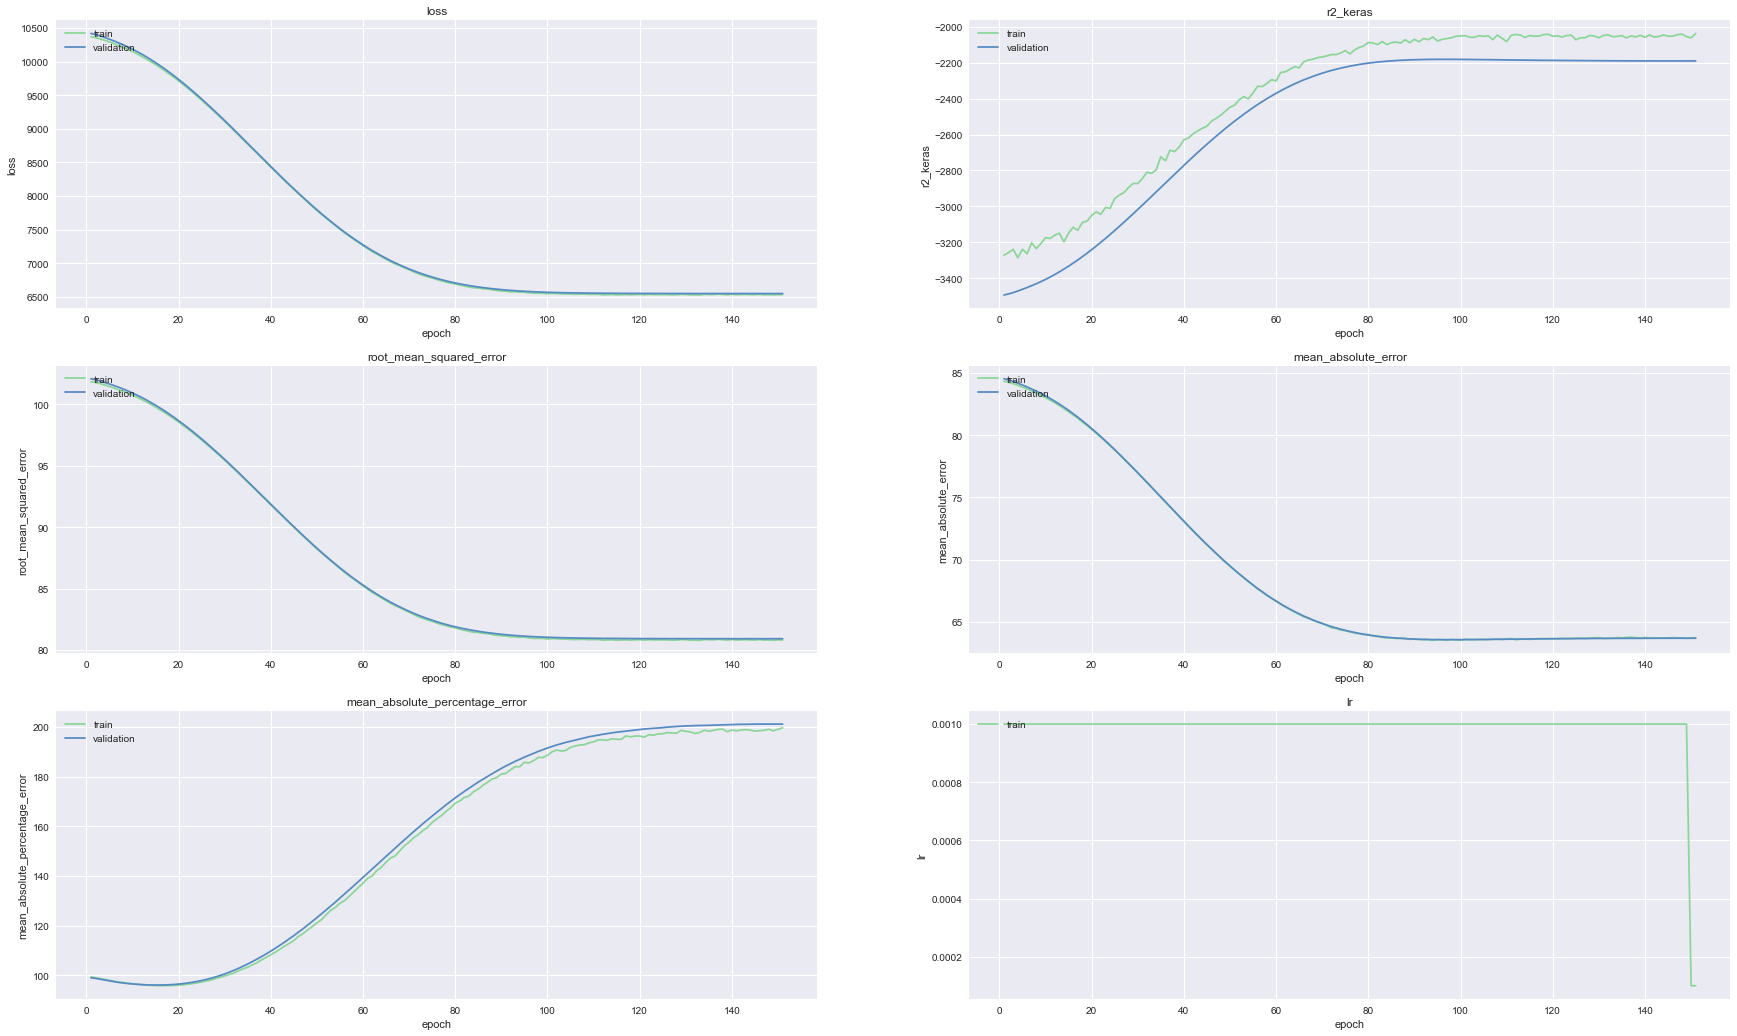

In [15]:
plot_model_history(modelo_01_history)

In [16]:
nome=modelo_01.name
path = f'prediction/TF/'
if not os.path.exists(path):
    os.makedirs(path)

y_pred_max_runtime = modelo_01.predict(X_test_max)
prediction=pd.DataFrame({"predicted":y_pred_max_runtime.reshape(-1)})
prediction.to_csv(path + f'/04_{nome}_prediction.csv',sep=',',index=False)

In [17]:
nome=modelo_01.name
path = f'models/TF/{nome}'
if not os.path.exists(path):
    os.makedirs(path)
    
# save the model to disk
modelo_01.save(path+ f'/model') 
pickle.dump( modelo_01_history.history, open(path + '/history.p', "wb" ) )
pickle.dump( metric_dict_01, open(path + '/results.p', "wb" ) )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/TF/Modelo_01/model\assets


# Modelo 02

In [15]:
def modelo_02(metrics,seq_array,label_array):
    model = None
    sequence_length = seq_array.shape[1]
    nb_features = seq_array.shape[2]
    nb_out = label_array.ndim

    model = Sequential(
      [
        LSTM(64, return_sequences=True,kernel_regularizer=L1L2(l1=0.0, l2=0.005),name='LSTM_01'),
        Dropout(0.2,name='Dropout_01'),
        GRU(64, return_sequences=True,kernel_regularizer=L1L2(l1=0.0, l2=0.005),name='GRU_01'),
        Dropout(0.2,name='Dropout_02'),
        LSTM(32, return_sequences=True, kernel_regularizer=L1L2(l1=0.0, l2=0.005),name='LSTM_02'),
        Dropout(0.2,name='Dropout_03'),
        GRU(32,kernel_regularizer=L1L2(l1=0.0, l2=0.005),name='GRU_02'),
        Dropout(0.2,name='Dropout_02'),
        Dense(1024, activation='relu',name='Dense'),
        Dense(nb_out, activation='linear',name='Output')
    ]
    ,name='Modelo_02'
    )

    model.compile(loss='mse',optimizer='adam',metrics=metrics)
    return model

In [16]:
modelo_02, modelo_02_history, metric_dict_02=cross_validate_tf_models(X_train=X_train
                                                                    ,Y_train=y_train
                                                                    ,X_test=X_test
                                                                    ,Y_test=y_test
                                                                    ,func_model=modelo_02
                                                                    ,metrics= metrics
                                                                    ,NUM_EPOCHS = NUM_EPOCHS
                                                                    ,N_FOLDS=N_FOLDS
                                                                    ,BATCH_SIZE=BATCH_SIZE
                                                                    ,scaler=MinMaxScalerND()
                                                                    ,seed = seed
                                                                    ,verbose=verbose
                                                                    ,callbacks=callbacks
                                                                    )

KeyboardInterrupt: 

In [ ]:
modelo_02.summary()

In [ ]:
plot_model_history(modelo_02_history)

In [ ]:
nome=modelo_02.name
path = f'prediction/TF/'
if not os.path.exists(path):
    os.makedirs(path)

y_pred_max_runtime = modelo_02.predict(X_test_max)
prediction=pd.DataFrame({"predicted":y_pred_max_runtime.reshape(-1)})
prediction.to_csv(path + f'/04_{nome}_prediction.csv',sep=',',index=False)

In [ ]:
nome=modelo_02.name
path = f'models/TF/{nome}'
if not os.path.exists(path):
    os.makedirs(path)
    
# save the model to disk
modelo_02.save(path+ f'/model') 
pickle.dump( modelo_02_history.history, open(path + '/history.p', "wb" ) )
pickle.dump( metric_dict_02, open(path + '/results.p', "wb" ) )

# Modelo 03

In [12]:
def modelo_03(metrics,seq_array,label_array):
    model = None

    model = Sequential(
      [
        Bidirectional(LSTM(128, return_sequences=True,kernel_regularizer=L1L2(l1=0.0, l2=0.00)),name='LSTM_01'),
        Dropout(0.2,name='Dropout_01'),
        Bidirectional(GRU(128, return_sequences=True,kernel_regularizer=L1L2(l1=0.0, l2=0.00)),name='LSTM_01'),
        Dropout(0.2,name='Dropout_02'),
        Bidirectional(LSTM(64,kernel_regularizer=L1L2(l1=0.0, l2=0.00),name='LSTM_03')),
        Dropout(0.2,name='Dropout_03'),
        Dense(256, activation = 'relu', name = 'Dense_01', kernel_regularizer=L1L2(l1=0.00, l2=0.00)),
        Dense(128, activation = 'relu', name = 'Dense_02', kernel_regularizer=L1L2(l1=0.00, l2=0.00)),
        Dropout(0.2,name='Dropout_04'),
        Dense(64, activation = 'relu', name = 'Dense_03', kernel_regularizer=L1L2(l1=0.00, l2=0.00)),
        Dense(32, activation = 'relu', name = 'Dense_04', kernel_regularizer=L1L2(l1=0.00, l2=0.00)),
        Dense(1, activation = 'linear', name = 'Output')
    ]
    ,name='Modelo_03'
    )

    
    model.compile(loss='mse',optimizer='adam',metrics=metrics)
    return model

In [13]:
modelo_03, modelo_03_history, metric_dict_03=cross_validate_tf_models(X_train=X_train
                                                                    ,Y_train=y_train
                                                                    ,X_test=X_test
                                                                    ,Y_test=y_test
                                                                    ,func_model=modelo_03
                                                                    ,metrics= metrics
                                                                    ,NUM_EPOCHS = NUM_EPOCHS
                                                                    ,N_FOLDS=N_FOLDS
                                                                    ,BATCH_SIZE=BATCH_SIZE
                                                                    ,seed = seed
                                                                    ,verbose=verbose
                                                                    ,callbacks=callbacks
                                                                    )


FOLD 01:
 - LOSS ->	 TRAIN: 3271.51 VALIDATION: 3252.94 TEST:2547.22
 - R2_KERAS ->	 TRAIN: -9.19 VALIDATION: -1.42 TEST:-56.46
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 57.20 VALIDATION: 57.03 TEST:50.47
 - MEANABSOLUTEERROR ->	 TRAIN: 46.29 VALIDATION: 45.86 TEST:43.03
 - MEANABSOLUTEPERCENTAGEERROR ->	 TRAIN: 280.92 VALIDATION: 292.70 TEST:464.17

Tempo de Execução: 3 horas 28 minutos e 42 segundos

FOLD 02:
 - LOSS ->	 TRAIN: 3263.86 VALIDATION: 3268.11 TEST:2551.03
 - R2_KERAS ->	 TRAIN: -8.61 VALIDATION: -1.63 TEST:-56.55
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 57.13 VALIDATION: 57.17 TEST:50.51
 - MEANABSOLUTEERROR ->	 TRAIN: 45.99 VALIDATION: 46.47 TEST:43.07
 - MEANABSOLUTEPERCENTAGEERROR ->	 TRAIN: 290.56 VALIDATION: 274.17 TEST:464.60

Tempo de Execução: 5 horas 0 minutos e 19 segundos


KeyboardInterrupt: 

In [14]:
modelo_03.summary()

AttributeError: 'function' object has no attribute 'summary'

In [15]:
plot_model_history(modelo_03_history)

NameError: name 'modelo_03_history' is not defined

In [ ]:
nome=modelo_03.name
path = f'prediction/TF/'
if not os.path.exists(path):
    os.makedirs(path)

y_pred_max_runtime = modelo_03.predict(X_test_max)
prediction=pd.DataFrame({"predicted":y_pred_max_runtime.reshape(-1)})
prediction.to_csv(path + f'/04_{nome}_prediction.csv',sep=',',index=False)

In [ ]:
nome=modelo_03.name
path = f'models/TF/{nome}'
if not os.path.exists(path):
    os.makedirs(path)
    
# save the model to disk
modelo_03.save(path+ f'/model') 
pickle.dump( modelo_03_history.history, open(path + '/history.p', "wb" ) )
pickle.dump( metric_dict_03, open(path + '/results.p', "wb" ) )

# Modelo 04

In [17]:
def modelo_04(metrics,seq_array,label_array):
    model = None
    sequence_length = seq_array.shape[1]
    nb_features = seq_array.shape[2]
    nb_out = label_array.ndim

    model = Sequential(
      [
        LSTM(32, kernel_regularizer=L1L2(l1=0.0, l2=0.005),name='LSTM_02'),
        Dropout(0.2,name='Dropout_03'),
        Dense(64, activation='relu',name='Dense'),
        Dense(nb_out, activation='linear',name='Output')
    ]
    ,name='Modelo_04'
    )

    model.compile(loss='mse',optimizer='adam',metrics=metrics)
    return model

In [18]:
modelo_04, modelo_04_history, metric_dict_04=cross_validate_tf_models(X_train=X_train
                                                                    ,Y_train=y_train
                                                                    ,X_test=X_test
                                                                    ,Y_test=y_test
                                                                    ,func_model=modelo_04
                                                                    ,metrics= metrics
                                                                    ,NUM_EPOCHS = NUM_EPOCHS
                                                                    ,N_FOLDS=N_FOLDS
                                                                    ,BATCH_SIZE=BATCH_SIZE
                                                                    ,scaler=MinMaxScalerND()
                                                                    ,seed = seed
                                                                    ,verbose=verbose
                                                                    ,callbacks=callbacks
                                                                    )


FOLD 01:
 - LOSS ->	 TRAIN: 1320.05 VALIDATION: 1223.81 TEST:5926.07
 - R2_KERAS ->	 TRAIN: -5.10 VALIDATION: -0.00 TEST:-51.71
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 36.33 VALIDATION: 34.98 TEST:76.98
 - MEANABSOLUTEERROR ->	 TRAIN: 24.43 VALIDATION: 23.68 TEST:64.75
 - MEANABSOLUTEPERCENTAGEERROR ->	 TRAIN: 29.39 VALIDATION: 28.18 TEST:398.18

Tempo de Execução: 1 minutos e 24 segundos

FOLD 02:
 - LOSS ->	 TRAIN: 1830.05 VALIDATION: 1879.81 TEST:4721.60
 - R2_KERAS ->	 TRAIN: -6.10 VALIDATION: -0.77 TEST:-41.69
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 42.78 VALIDATION: 43.35 TEST:68.71
 - MEANABSOLUTEERROR ->	 TRAIN: 31.52 VALIDATION: 31.88 TEST:58.67
 - MEANABSOLUTEPERCENTAGEERROR ->	 TRAIN: 67.73 VALIDATION: 66.18 TEST:411.08

Tempo de Execução: 55 segundos

FOLD 03:
 - LOSS ->	 TRAIN: 938.04 VALIDATION: 970.91 TEST:6052.75
 - R2_KERAS ->	 TRAIN: -2.76 VALIDATION: 0.01 TEST:-51.11
 - ROOTMEANSQUAREDERROR ->	 TRAIN: 30.62 VALIDATION: 31.15 TEST:77.80
 - MEANABSOLUTEERROR ->	 TRAIN: 20.34 VA

In [19]:
modelo_04.summary()

Model: "Modelo_04"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM_02 (LSTM)               multiple                  5504      
_________________________________________________________________
Dropout_03 (Dropout)         multiple                  0         
_________________________________________________________________
Dense (Dense)                multiple                  2112      
_________________________________________________________________
Output (Dense)               multiple                  65        
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________


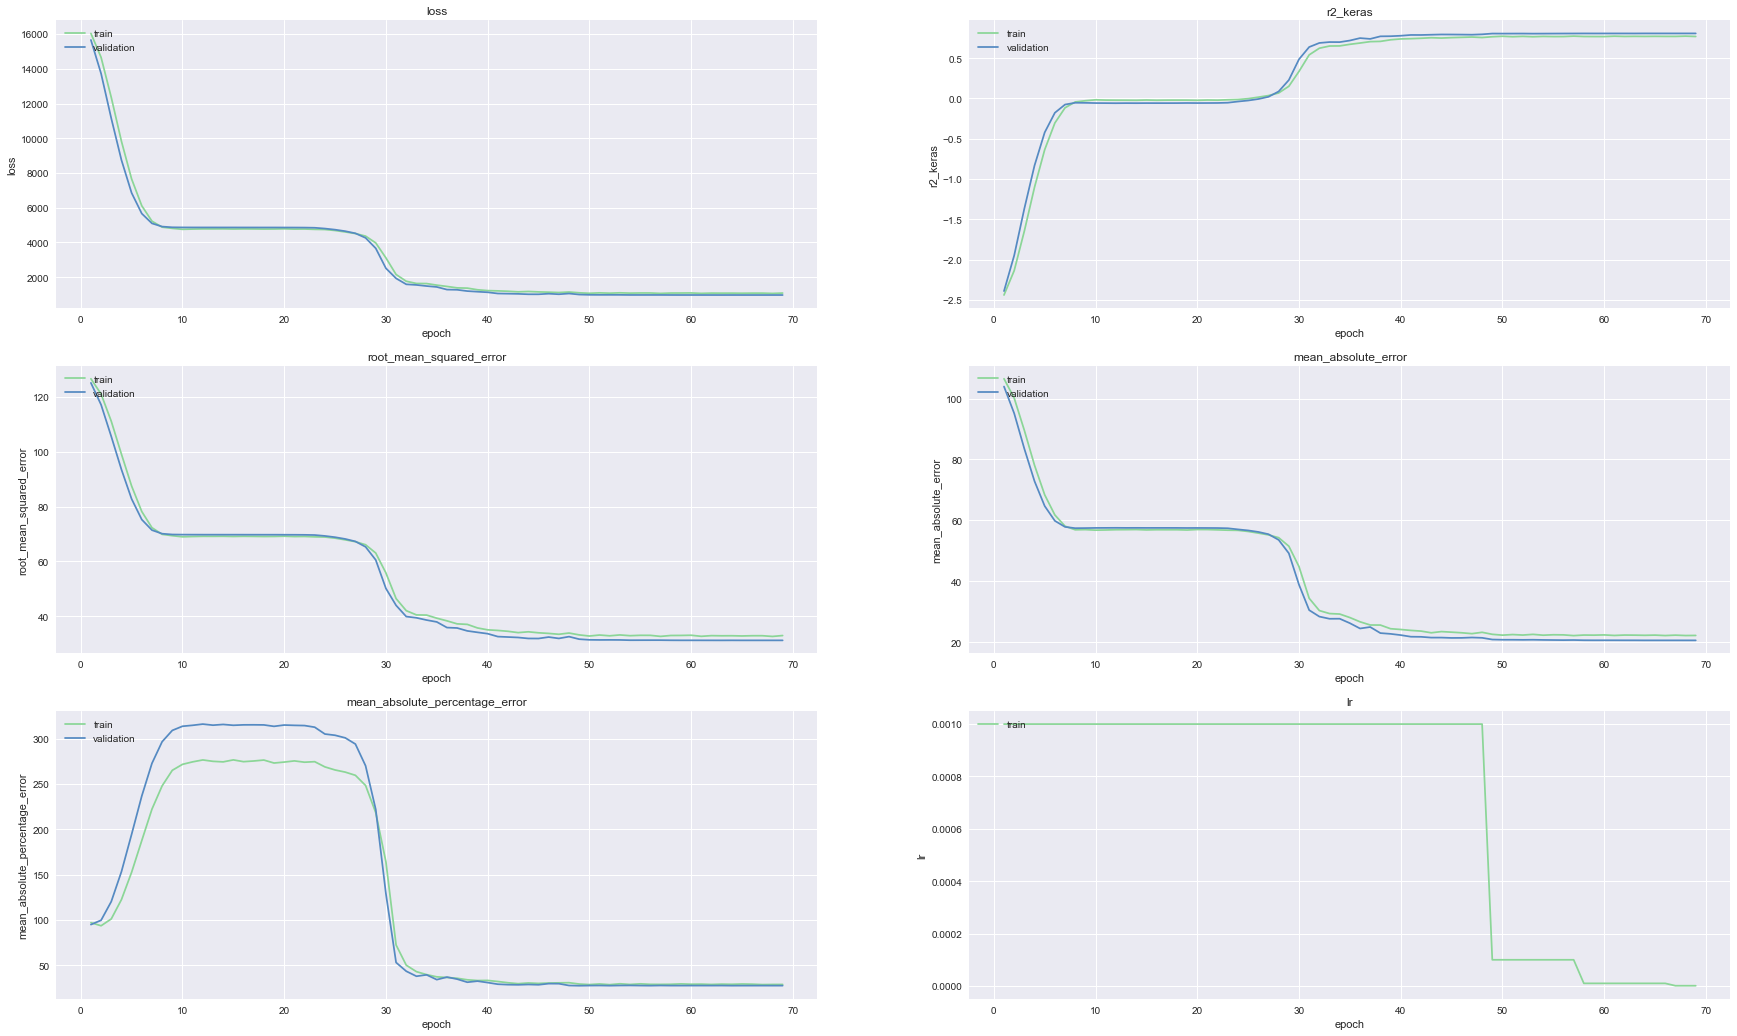

In [20]:
plot_model_history(modelo_04_history)

In [19]:
nome=modelo_04.name
path = f'prediction/TF/'
if not os.path.exists(path):
    os.makedirs(path)

y_pred_max_runtime = modelo_04.predict(X_test_max)
prediction=pd.DataFrame({"predicted":y_pred_max_runtime.reshape(-1)})
prediction.to_csv(path + f'/04_{nome}_prediction.csv',sep=',',index=False)

In [20]:
nome=modelo_04.name
path = f'models/TF/{nome}'
if not os.path.exists(path):
    os.makedirs(path)
    
# save the model to disk
modelo_04.save(path+ f'/model') 
pickle.dump( modelo_04_history.history, open(path + '/history.p', "wb" ) )
pickle.dump( metric_dict_04, open(path + '/results.p', "wb" ) )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/TF/Modelo_04/model\assets


# Conclusão RNN
- Devido a limitação de poder computacional e tempo disponibilizado, foi necessário optar por modelos mais enxutos
- Os modelos apresentados performaram pior em relação ao teste considerando as métricas de treino, porém ainda existe muito potencial nesta técnica
- Possíveis próximos passos seriam:
    - Criar modelos maiores e mais robustos
    - Transfer Learning para cálculo de RUL (https://arxiv.org/abs/1909.07053)
    - Técnicas como Processamento de imagens (https://towardsdatascience.com/remaining-life-estimation-with-keras-2334514f9c61)
    - Time series analysis (https://towardsdatascience.com/time-series-analysis-for-predictive-maintenance-of-turbofan-engines-1b3864991da4)
    - Feature Engineering (https://towardsdatascience.com/the-importance-of-problem-framing-for-supervised-predictive-maintenance-solutions-cc8646826093)
    - Entre outras